# Geodesic Runtime

In [1]:
import jax.numpy as jnp

import os

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from tabulate import tabulate

In [2]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
geometry = "riemannian"
T = 100
path = f'timing/{geometry}/'
manifold = "Landmarks"
figure_path = '../figures/geodesic_runtime/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [5]:
save_path = ''.join((path, manifold, '/'))

In [6]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}' in f]

In [7]:
estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    dim = file.replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    estimates[dim] = values

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Table Comparison

In [8]:
dims = list(estimates.keys())

mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
length = [estimates[key3][key2]['length'] for key3,v3 in estimates.items()for key2,v2 in v3.items()]
iter_num = [estimates[key3][key2]['iterations'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
grad_norm = [estimates[key3][key2]['grad_norm'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
max_iter = [estimates[key3][key2]['max_iter'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
tol = [estimates[key3][key2]['tol'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
method = [key2 for key3,v3 in estimates.items() for key2,v2 in v3.items()]
dims = [key3 for key3,v3 in estimates.items() for key2,v2 in v3.items()]

N_methods = len(list(set(method)))
#dims = sum([[d]*N_methods for d in dims], [])

In [9]:
names = [r"Dim", r"Method", 
        r"Length", r"Iterations", r"grad_norm", r"mean time",
        r"std time", r"max_iter", r"tol"]

table_dict = {}
table_dict['Dim'] = dims
table_dict['Method'] = method
table_dict['Length'] = length
table_dict['Iterations'] = iter_num
table_dict['grad_norm'] = grad_norm
table_dict['mu_time'] = mu_time
table_dict['std_time'] = std_time
table_dict['max_iter'] = max_iter
table_dict['tol'] = tol

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  Dim  Method          Length    Iterations    grad_norm    mean time    std time    max_iter     tol
-----  ------------  --------  ------------  -----------  -----------  ----------  ----------  ------
    2  GEORCE         17.7698        7.0000       0.0001       0.0244      0.0008      100000  0.0001
    2  init           17.3969                                                          100000  0.0001
    2  ground_truth                                                                    100000  0.0001


## Plotting Comparison

In [10]:
methods = [list(estimates[k].keys()) for k,v in estimates.items()]

In [ ]:
color = ['red', 'blue', 'green', 'purple']

fig = plt.figure(figsize=(20,10))
i_last = len(methods)-1

ax = fig.add_subplot(121)
for i in range(len(methods)):
    n_dims = methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items() if key2==m]
            std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            std_time = [x for _, x in sorted(zip(dims, std_time))]
            mu_time, std_time, dims = jnp.stack(mu_time), jnp.stack(std_time), jnp.stack(dims)
            ax.plot(dims, mu_time, '-o', color=color[j])
            ax.fill_between(
                            dims,
                            jnp.maximum(mu_time - 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            jnp.maximum(mu_time + 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            alpha=0.1,
                        )
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.grid(True)

ax = fig.add_subplot(122)
for i in range(len(methods)):
    n_dims = methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [estimates[key3][key2]['length'] for key3,v3 in estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            if i == i_last:
                ax.plot(dims, mu_time, '-o', label=m, color=color[j])
            else:
                ax.plot(dims, mu_time, '-o', color=color[j])
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.2), ncol=5)

plt.show()

save_path = f'{figure_path}{manifold}_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

## Plotting $\mathbb{S}^{n}$ and Ellipsoid(n) for $T=100$

In [37]:
T = 100
path = 'timing/'
figure_path = '../figures/geodesic_runtime/'

In [38]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading $\mathbb{S}^{n}$

In [39]:
save_path = ''.join((path, "Sphere", '/'))

In [40]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}' in f]

In [41]:
sphere_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    dim = file.replace("Sphere", '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    sphere_estimates[dim] = values

## Loading Ellipsoid(n)

In [42]:
save_path = ''.join((path, "Ellipsoid", '/'))

In [43]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}' in f]

In [44]:
ellipsoid_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    dim = file.replace("Ellipsoid", '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    ellipsoid_estimates[dim] = values

## Table Comparison

In [45]:
sphere_methods = [list(sphere_estimates[k].keys()) for k,v in sphere_estimates.items()]
ellipsoid_methods = [list(ellipsoid_estimates[k].keys()) for k,v in ellipsoid_estimates.items()]

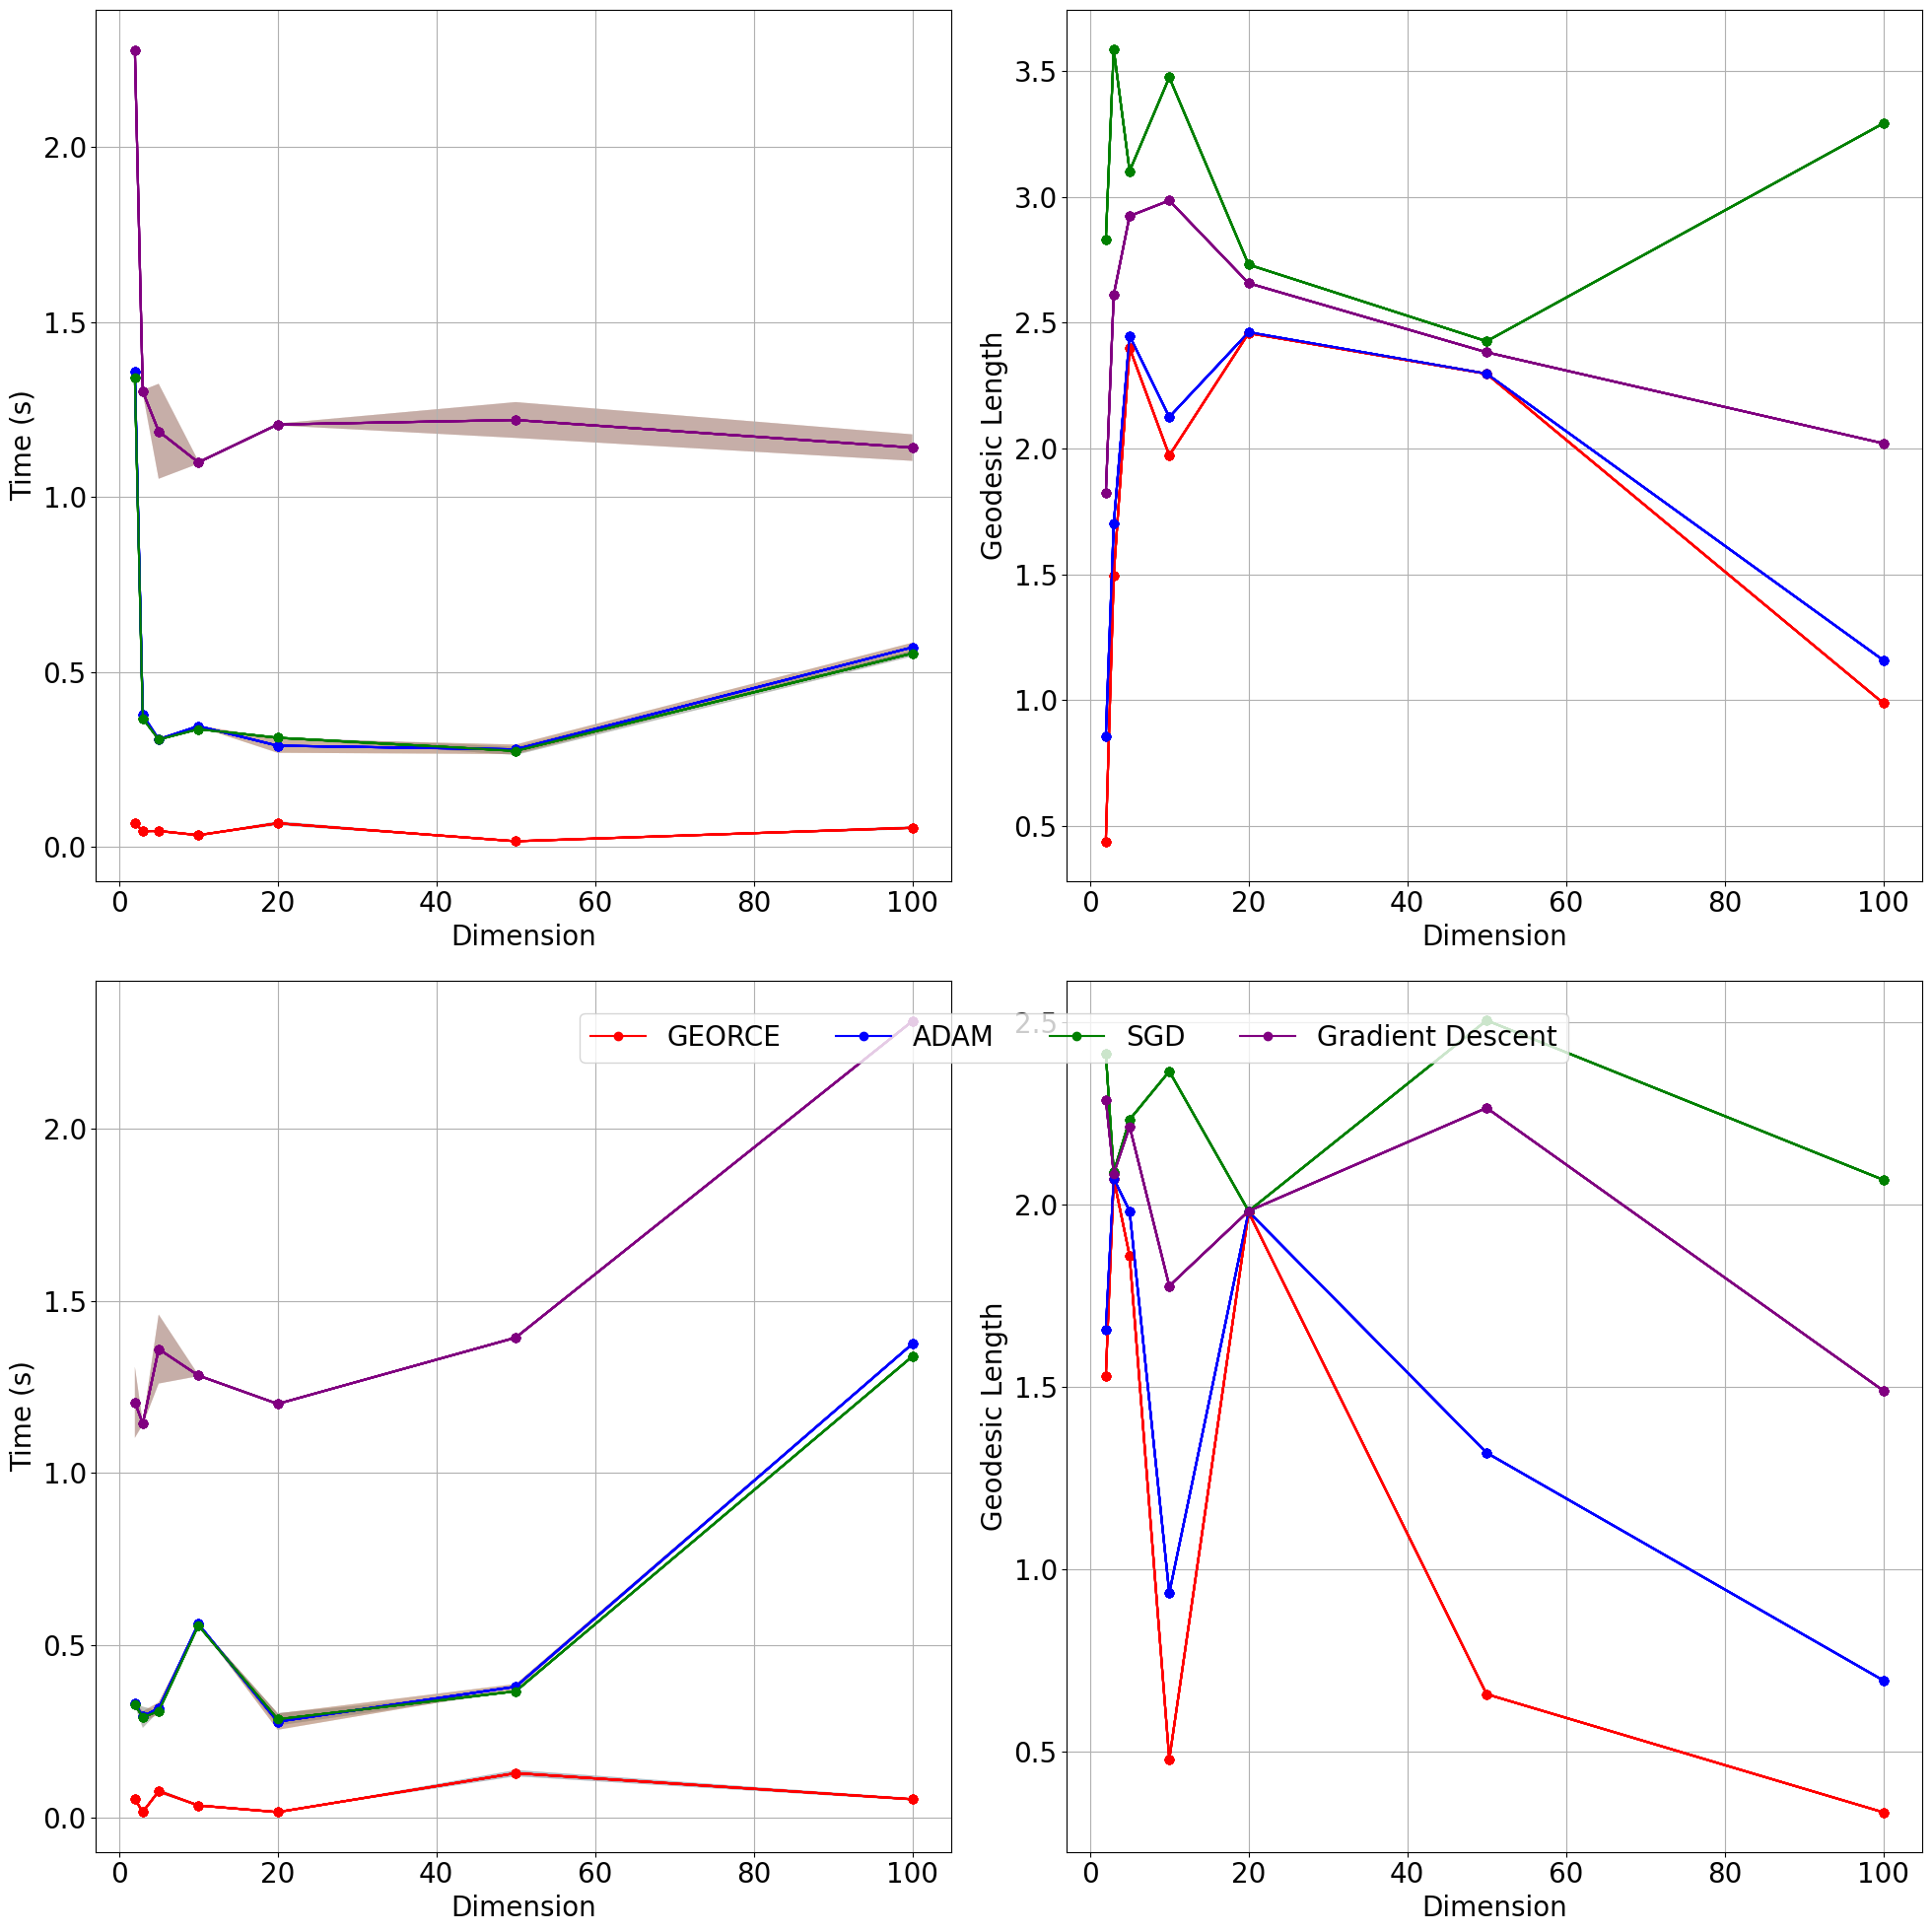

In [46]:
color = ['red', 'blue', 'green', 'purple']

fig = plt.figure(figsize=(20,20))
i_last = len(sphere_methods)-1

ax = fig.add_subplot(221)
for i in range(len(sphere_methods)):
    n_dims = sphere_methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [sphere_estimates[key3][key2]['mu_time'] for key3,v3 in sphere_estimates.items() for key2,v2 in v3.items() if key2==m]
            std_time = [sphere_estimates[key3][key2]['std_time'] for key3,v3 in sphere_estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in sphere_estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            std_time = [x for _, x in sorted(zip(dims, std_time))]
            mu_time, std_time, dims = jnp.stack(mu_time), jnp.stack(std_time), jnp.stack(dims)
            ax.plot(dims, mu_time, '-o', color=color[j])
            ax.fill_between(
                            dims,
                            jnp.maximum(mu_time - 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            jnp.maximum(mu_time + 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            alpha=0.1,
                        )
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.grid(True)

ax = fig.add_subplot(222)
for i in range(len(sphere_methods)):
    n_dims = sphere_methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [sphere_estimates[key3][key2]['length'] for key3,v3 in sphere_estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in sphere_estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            if i == i_last:
                ax.plot(dims, mu_time, '-o', color=color[j])
            else:
                ax.plot(dims, mu_time, '-o', color=color[j])
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.grid(True)

i_last = len(ellipsoid_methods)-1

ax = fig.add_subplot(223)
for i in range(len(ellipsoid_methods)):
    n_dims = ellipsoid_methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [ellipsoid_estimates[key3][key2]['mu_time'] for key3,v3 in ellipsoid_estimates.items() for key2,v2 in v3.items() if key2==m]
            std_time = [ellipsoid_estimates[key3][key2]['std_time'] for key3,v3 in ellipsoid_estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in ellipsoid_estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            std_time = [x for _, x in sorted(zip(dims, std_time))]
            mu_time, std_time, dims = jnp.stack(mu_time), jnp.stack(std_time), jnp.stack(dims)
            ax.plot(dims, mu_time, '-o', color=color[j])
            ax.fill_between(
                            dims,
                            jnp.maximum(mu_time - 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            jnp.maximum(mu_time + 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            alpha=0.1,
                        )
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.grid(True)

ax = fig.add_subplot(224)
for i in range(len(ellipsoid_methods)):
    n_dims = ellipsoid_methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [ellipsoid_estimates[key3][key2]['length'] for key3,v3 in ellipsoid_estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in ellipsoid_estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            if i == i_last:
                ax.plot(dims, mu_time, '-o', label=m, color=color[j])
            else:
                ax.plot(dims, mu_time, '-o', color=color[j])
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.30,0.45), ncol=5)



fig.tight_layout()

plt.show()

save_path = f'{figure_path}sphere_ellipsoid_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')